# AlgoSB 2021

Practical afternoon session Monday, 8th of November. Time-series analysis, covering:

  - Principle component analysis
  - Time-lagged independent analysis
  - Clustering
  - MSM estimation

In [38]:
from dataclasses import dataclass
import sys
import warnings

from cnnclustering import cluster
import  matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import scipy
from scipy.stats import multivariate_normal
import sklearn
from sklearn import decomposition

In [39]:
# Version information
print("Python: ", *sys.version.split("\n"))

print("Packages:")
for package in [mpl, np, scipy, pyemma]:
    print(f"    {package.__name__}: {package.__version__}")

Python:  3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:57:06)  [GCC 9.4.0]
Packages:
    matplotlib: 3.2.2
    numpy: 1.21.3
    scipy: 1.7.1
    pyemma: 2.5.9


In [40]:
# Matplotlib configuration
mpl.rc_file(
    "../matplotlibrc",
    use_default_template=False
)

In [43]:
warnings.simplefilter("ignore")

## Motivation

## Outline and organisation

We will demonstrate a few types of analyses that can be used in Markov-model estimation workflows on Molecular Dynamics data. Instead of "real world" MD trajectories, we will use artificial time-series that we produce as follows:

  - We define a **transition-probability matrix** for a number of (conformational) states. An element $ij$ in this matrix denotes the observation probability for a (conformational) transition from state $i$ to state $j$ within a time-step.
  - Starting from this matrix, we generate a possible time-series in state space, i.e. a **discrete trajectory**, which reflects the given transition probabilities.
  - Next, we define our states in terms of underlying **probability distributions** in a **feature space** (e.g. multivariate gaussians).
  - For each time-step in the discrete time-series, we draw a (conformational) sample from the distribution of the  corresponding state to generate a **continuous trajectory**
  - The continuous trajectory (conformational snapshots in the feature space) are subjected to different analyses.

<div class="alert alert-info">

**Note:** In a "real" analysis we would proceed basically the other way round. Starting from a trajectory trough a continuous feature space obtained by a MD simulation, we want to produce a discrete trajectory (e.g. trough clustering) to finally estimate a transition probability matrix that describes our system.
</div>

To organise the "systems" we investigate in this exercise, let's use a simple wrapping object to collect everything a system is made of:

In [4]:
@dataclass
class System:
    desc: str
    transition_p_matrix: np.ndarray = None
    dtraj: np.ndarray = None
    state_distr_map: dict = None
    traj: np.ndarray = None
    pca=None
    tica=None

## Data set generation

In [5]:
system_intro = System("Introductory example")
system = system_intro

### Transition probability matrix and time-series over states

In [6]:
# Arbitrary transition probabilities for three states
system.transition_p_matrix = np.array([
    [0.98, 0.00, 0.02],
    [0.00, 0.89, 0.11],
    [0.02, 0.11, 0.87],
])

In [7]:
# Dummy MSM from transition probabilities
sampled_msm = pyemma.msm.SampledMSM(system.transition_p_matrix)
system.dtraj = sampled_msm.simulate(5000)

In [8]:
system.dtraj[:30]

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2])

### Probability distributions for states in feature space

In [9]:
def make_state_distributions(centers, covs):
    """Create a mapping of state IDs to gaussian distributions"""

    return {
        index: multivariate_normal(mean=center, cov=cov)
        for index, (center, cov) in enumerate(zip(centers, covs))
    }

In [10]:
state_centers = np.array([
    [-1, 1],
    [1, -1],
    [2, 2],
])
state_covs = np.array([
    [[0.1, 0.0],
     [0.0, 0.3]],
    [[0.4, 0.0],
     [0.0, 0.4]],    
    [[0.2, 0.0],
     [0.0, 0.2]],
])

In [11]:
system.state_distr_map = make_state_distributions(state_centers, state_covs)

In [12]:
# Draw a random point from a state distribution
make_state_distributions(state_centers, state_covs)[0].rvs()

array([-0.36593109,  1.1729612 ])

### Continuous trajectory through feature space

In [13]:
def sample_trajectory_from_discrete(dtraj, mapping):
    """Map discrete state trajectory to random conformational samples"""
    return np.array([
        mapping[state].rvs()
        for state in dtraj
    ])

In [14]:
system.traj = sample_trajectory_from_discrete(
    system.dtraj,
    system.state_distr_map
)

In [15]:
def get_transition_points(dtraj):
    """Determine state transition points in discrete trajectory"""
    inter_state_transitions = []

    for i, state in enumerate(dtraj[1:]):
        last_state = dtraj[i]

        if state != dtraj[i]:
            inter_state_transitions.append(i)
            
    return inter_state_transitions

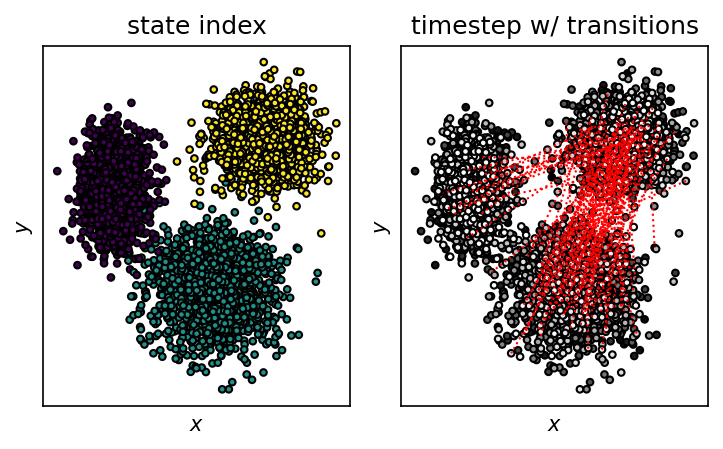

In [16]:
fig, (state_ax, time_ax) = plt.subplots(1, 2)
state_ax.scatter(
    *system.traj.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)
time_ax.scatter(
    *system.traj.T,
    c=np.arange(system.traj.shape[0]),
    s=10,
    edgecolors="k", linewidths=1,
    cmap=mpl.cm.gray
)

for i in get_transition_points(system.dtraj):
    if i % 5 != 0:
        continue
    start = system.traj[i]
    end = system.traj[i + 1]
    time_ax.plot(
        [start[0], end[0]], [start[1], end[1]],
        color="red", linestyle="dotted", linewidth=1,
    )

for ax in (state_ax, time_ax):
    ax.set(**{
        "aspect": "equal",
        "xticks": (),
        "yticks": (),
        "xlabel": "$x$",
        "ylabel": "$y$"
    })
    
state_ax.set_title("state index")
time_ax.set_title("timestep w/ transitions")

fig.tight_layout()

## Principle component analysis

In [17]:
system = system_intro

__Exercise__ Use `sklearn.decomposition.PCA`

In [18]:
system.pca = decomposition.PCA(2)
system.pca.fit(system.traj)

PCA(n_components=2)

In [19]:
components = system.pca.components_
components

array([[ 0.79036289,  0.61263897],
       [ 0.61263897, -0.79036289]])

In [20]:
projected_trajectory = system.pca.transform(system.traj)

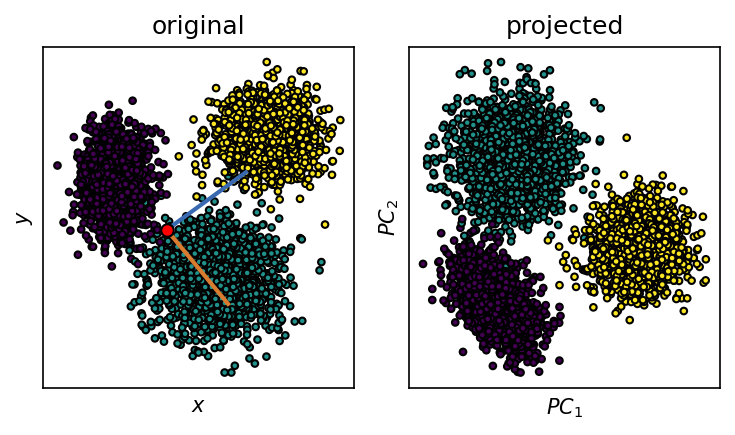

In [21]:
fig, (o_ax, p_ax) = plt.subplots(1, 2)
o_ax.scatter(
    *system.traj.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)

scale = 2
o_ax.plot([0, components[0, 0] * scale], [0, components[0, 1] * scale], linewidth=2)
o_ax.plot([0, components[1, 0] * scale], [0, components[1, 1] * scale], linewidth=2)
o_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")

p_ax.scatter(
    *projected_trajectory.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)
o_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$x$",
    "ylabel": "$y$",
    "title": "original"
})

p_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$PC_1$",
    "ylabel": "$PC_2$",
    "title": "projected"
})

fig.tight_layout()

In [22]:
system.pca.explained_variance_ratio_

array([0.57535202, 0.42464798])

### Correlation

__Exercise__ Use `numpy.corrcoef` to calculate the the Pearson correlation coefficient between the two original coordinates and the between the obtained principle components. What do  you observe?

In [23]:
corrcoeff = np.corrcoef(trajectory[:, 0], trajectory[:, 1])[0, 1]
corrcoeff_projected = np.corrcoef(projected_trajectory[:, 0], projected_trajectory[:, 1])[0, 1]
print(f"Correlation (original):  {corrcoeff}")
print(f"Correlation (projected): {corrcoeff_projected}")

NameError: name 'trajectory' is not defined

## Time-lagged independent component analysis

In [27]:
system.tica = pyemma.coordinates.tica(system.traj, var_cutoff=1)

In [28]:
tica_components = system.tica.eigenvectors.T
tica_components

array([[ 0.42932894, -0.17255014],
       [ 0.01011721,  0.0411512 ]])

In [29]:
system.tica.describe()

'[TICA, lag = 10; max. output dim. = 2]'

In [30]:
system.tica.cumvar

array([0.99073239, 1.        ])

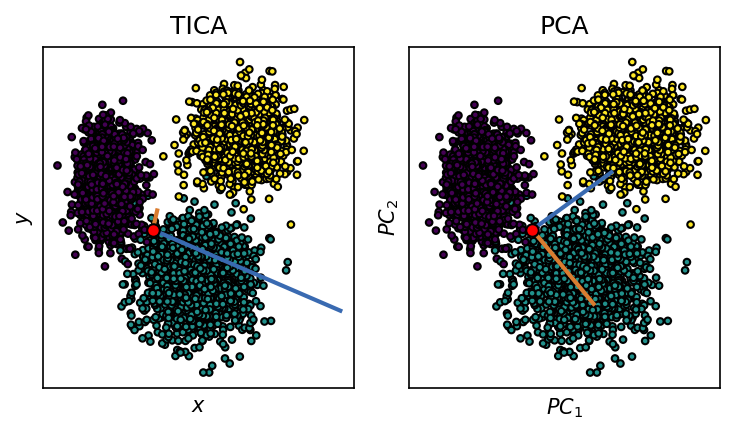

In [31]:
fig, (tica_ax, pca_ax) = plt.subplots(1, 2)
tica_ax.scatter(
    *system.traj.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)

scale = 10
tica_ax.plot([0, tica_components[0, 0] * scale], [0, tica_components[0, 1] * scale], linewidth=2)
tica_ax.plot([0, tica_components[1, 0] * scale], [0, tica_components[1, 1] * scale], linewidth=2)
tica_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")

pca_ax.scatter(
    *system.traj.T,
    c=system.dtraj,
    s=10,
    edgecolors="k", linewidths=1
)

scale = 2
pca_ax.plot([0, system.pca.components_[0, 0] * scale], [0, system.pca.components_[0, 1] * scale], linewidth=2)
pca_ax.plot([0, system.pca.components_[1, 0] * scale], [0, system.pca.components_[1, 1] * scale], linewidth=2)
pca_ax.plot([0], [0], markerfacecolor="red", marker="o", markeredgecolor="k")

tica_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$x$",
    "ylabel": "$y$",
    "title": "TICA"
})

pca_ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlabel": "$PC_1$",
    "ylabel": "$PC_2$",
    "title": "PCA"
})

fig.tight_layout()

## Clustering to generate discrete trajectories

In [32]:
clustering = cluster.Clustering(np.concatenate(system.tica.get_output()))

In [33]:
clustering.fit(0.05, 50, member_cutoff=10)

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
5000      0.050     50        10        None      3         0.342     0.107     00:00:1.214
-----------------------------------------------------------------------------------------------



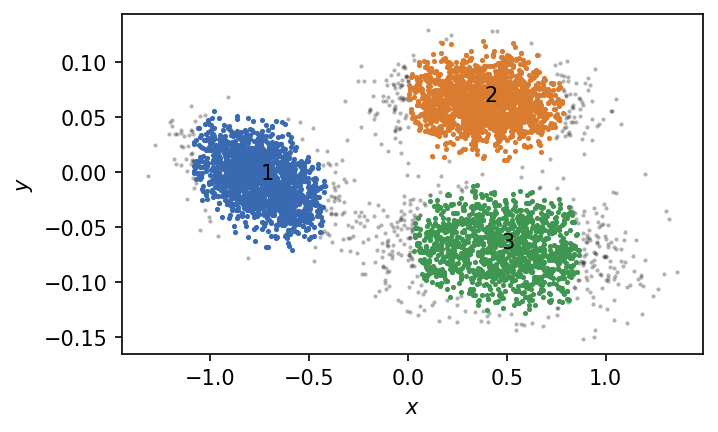

In [34]:
_ = clustering.evaluate()

## MSM estimation

In [44]:
dtrajs = [a - 1 for a in clustering.to_dtrajs()]

In [45]:
dtrajs

[array([2, 2, 2, ..., 1, 1, 1])]

In [46]:
its = pyemma.msm.its(dtrajs, lags=[1, 2, 3, 5, 7, 10], nits=3)

estimating MaximumLikelihoodMSM:   0%|                  | 0/6 [00:00<?, ?it/s]

25-10-21 18:09:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
25-10-21 18:09:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
25-10-21 18:09:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
25-10-21 18:09:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.


estimating MaximumLikelihoodMSM:  17%|█▋        | 1/6 [00:00<00:00,  7.71it/s]

25-10-21 18:09:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[6] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.
25-10-21 18:09:52 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[6] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 36.70it/s]


25-10-21 18:09:52 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[3] WARNING  Changed user setting nits to the number of available timescales nits=2


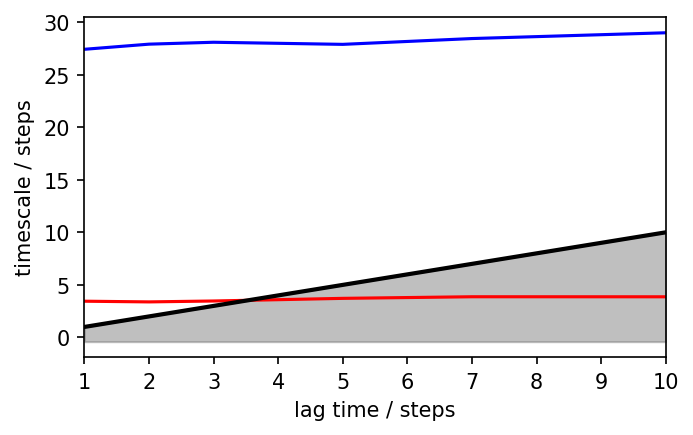

In [47]:
pyemma.plots.plot_implied_timescales(its, ylog=False)

In [48]:
MSM = pyemma.msm.estimate_markov_model(dtrajs, lag=2)

25-10-21 18:10:02 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[5] WARNING  Empty core set while unassigned states (-1) in discrete trajectory. Defining core set automatically; check correctness by calling self.core_set.


In [50]:
MSM.P

array([[0.95426996, 0.04215855, 0.00357149],
       [0.0432103 , 0.7700565 , 0.1867332 ],
       [0.0046127 , 0.23530237, 0.76008493]])

## Scratch

In [109]:
def multivar_gaussian_pdf(x, cov, mu):
    """Multivariate gaussian PDF"""
    
    n = x.shape[0]
    
    assert n == mu.shape[0] == cov.shape[0] == cov.shape[1], f"! {n} == {mu.shape[0]} == {cov.shape[0]} == {cov.shape[1]}"
    
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    
    delta_xm = x - mu
    
    return 1 / ((2 * np.pi)**(n/2) * np.sqrt(det)) * np.exp(-0.5 * (delta_xm.T @ inv @ delta_xm))